# Homework 5. Transformers for token classification
Max Base Points: 15
- [x] Introduce fixes, mentioned in `TODO`s
- [x] Your model also have to handle ukrainian and russian languages. Make sure to add `../data/mantis_analytics_location_detection/ru_geo_dataset.csv` (from https://www.kaggle.com/datasets/vladimirsydor/mantis-analytics-location-detection/data). Think about
    - New Validation
    - New Word Embeddings
    - Maybe separate models
    - IMPORTANT: Take into account `doc_id`
    - Take into account that markup is far from ideal. Maybe pre-processing may help
- [ ] Coming back to Lecture 3. F1 is the final production metric but it strongly depends on threshold. Maybe you can use some "soft" metric for model comparison ? 
- [x] Do we need additional post-processing ?
- [x] Tune `BERT` / `DEBERTA` or other bert-like models on the whole dataset for more epochs, maybe re-write it. Tune all other hyper-params.
- [ ] Try different optimizers lr schedulers 
- [ ] Implement Cross-Validation and add test houldout
- [x] Make a submit to Kaggle
- [ ] Additional points: first private score - 25 points, second private score - 15 points, third private score - 10 points
- [ ] Do not hesitate to use `Discussion` and `Code` on Kaggle. All additional useful insights will be also granted with additional scores
- [x] If you do not want to share with other competitors - you can share with lectors. It can be useful for Mantis usecase 

## General thoughts and approaches 

I thought of two possible approaches to deal with the two-languages nature of the test data:
- Train two separate models for the uk and ru NER, on the inference detect the language of the sample with auxiliary model first and apply correspondent trained model after
- Train multilingual model on the dataset which includes samples from both languages, with the same proportion as in the test data 

At first glance it's not obvious which one should work better. Inserting step with language detection adds one more possible source of error, which may be a bottleneck, because if language detected incorrectly, it will be supplied to the model for another one and likely won't output meaningful result. On the other hand, specialized models expected to have much better performance on the one language than the general one, so high performance on the correctly detected samples may compensate poor performance on the wrong one. 

Taking this into account, I decided to try both approaches.

## Combined multibert

1. My first intention was to create combined dataset, which includes ukrainian and russian samples in the same proportion as in the test set, since I noticed that test set is strongly disbalanced in this sense. To save gpu time (I have 30hr per week from the kaggle) and be able to conduct different experiments, I used a part of the uk dataset with `100k` samples. Languages ratios I calculated on the test set with `langid` module. 

Training code for this case can be found here: [multibert_combined_train_1.ipynb](multibert_combined_train_1.ipynb). Result of this model on LB is below

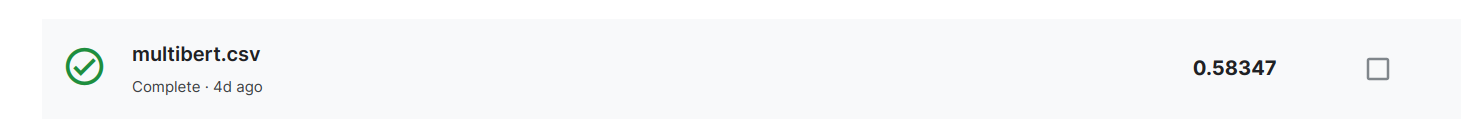

2. Lang ratio in the test dataset is approximetely `8`, i.e. there are `8` times more uk samples than ru ones. Taking `100k` uk samples for training means that in previous approach for ru will be taken only about `12k` samples. I wasn't sure if this can be enough for model fine-tuning and decided to try to train model on the dataset where there is the same number of ru samples as uk ones. For this I took `100k` uk and `100k` ru samples from the original dataset. Also, I noticed that in the uk dataset there are only `10k` samples proposed for validation, so I take them all instead of sampling too.

Script for creating these versions of datasets is placed here: [create_light_versions.ipynb](create_light_versions.ipynb).

Training notebook: [multibert-combined_train_2.ipynb](multibert-combined_train_2.ipynb).

Interestingly enough, this model scores much worse on the LB although it had more training data, indicating that preserving languages balance in the training dataset seems to be crucial

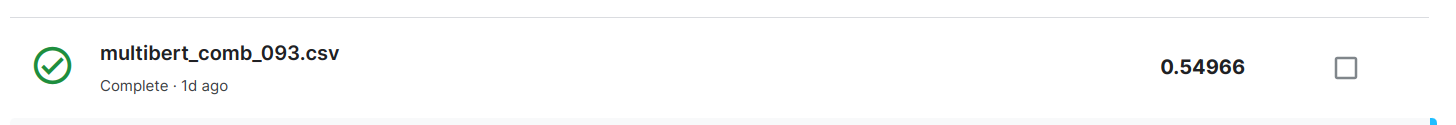

In order to choose suitable threshold for entities score (0.93 in this case) I used `labeling_sample.csv` data, as it's the most close one to the real test set that we have. Since it's very small, it's not a perfect solution, yet calibrating threshold on this data boosted LB performance of the models a bit. This procedure can be observed for example in the inference notebook [multibert_combined_inference.ipynb](multibert_combined_inference.ipynb)

## Separated models 

For separated models I use `langid` module for language detection, because it allows restricting prediction to two languages from the box. Its performance estimation and small modification are placed here: [lang_detection.ipynb](lang_detection.ipynb). 


There were two possibilities (at least two) for base uk ner base model: multibert and youscan/roberta-uk. I suspected that pre-trained uk model should perform better, and set up experiment to check this hypothesis, with two models which differ only in `uk` component: 
- `langid`, `multibert` fine-tune for `uk`, `spacy` pre-trained ner for `ru`
- `langid`, `roberta-uk` fine-tune for `uk`, `spacy` pre-trained ner for `ru`

Here is a training notebook for the roberta-uk: [roberta_uk.ipynb](roberta_uk.ipynb)

Unexpectedly, fine-tuning uk model on the `multibert` under the same training conditions performed much better. 

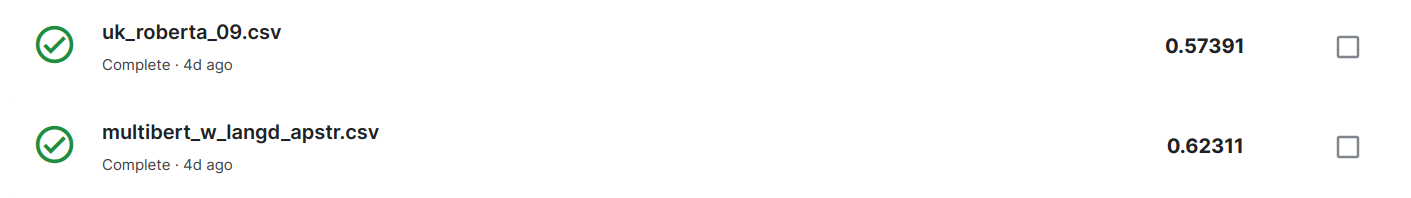

So for further trials I stick to the multibert base for both uk and ru models.

With this in mind I also fine-tuned ru model on the multibert base (on the 100k dataset) and tuned threshold. This with minimal threshold tuning boosted LB score a bit further. 

ru model train notebook: [multibert_ru.ipynb](multibert_ru.ipynb)

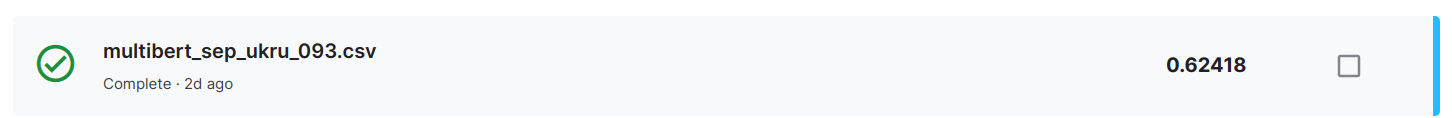

**ToDo** separate thresholds for uk and ru models

**ToDo** implement correct validation metric

**ToDo** investigate threshold tuning possibilities 

## Validation nuances

Seqevel module (from the lecture's code) for validation metric calculation shows extreme scores, greater than `95%` on the first epoch, which suggests that it takes into account negative class (i.e. "O" label). This module supposed to calculate error on the entities level, but it's not clear whether it consider no-labelled entities and  I didn't find detailed description on how it is calculated on the [page](https://github.com/chakki-works/seqeval), to which huggingface's documentation refers. At the beginning I tried to adopt the metrics function from the previous hw, but also missed that it should operate on the entities level and therefore doesn't have much sense in current implementation. Therefore current validation results are not very representative, yet still acceptable for choosing the best checkpoint during training. I am going to rewrite validation function so that it fully coincides with the target metric, but haven't managed to complete this yet.

## Some additional insights

1. During the inspection of prediction of one of the models, I noticed that huggingface's token classification pipeline unites some punctuation tokens with spaces around, when they shouldn't be there. It concerns three variants of ukrainian apostroph and hyphen  (which sometimes appear in the address string). For example, model correctly recognized entity `вул. Л. Лукʼяненка, 13`, but in the final prediction it was represented as `вул. Л. Лук ʼ яненка, 13`. To deal with it, I added the next regex to the post-processing stage. It finds mentioned characters in the string and removes spaces around it. Also, this snippet removes entities which contain "#", as it indicates that the model took only part of the word.
```python
if ent['score'] >= th and "#" not in ent['word']:
    word = re.sub(r"\s*([ʼ\''-])\s*", r"\1", ent['word'])
    res.append(word)
```
This adds `0.02` points to LB score. I suspect that the same problem appears in the `nlp_ua_bert_baseline.csv`, as I had exactly the same score with it at some point.

**ToDo** think about more generalized approach -- match classified tokens with the original text and for the prediction return a substring of the original text

**ToDo** instead of removing entities with "#" try to attach previous missing token to them

2. Test set consists of messages from telegram channels and contains lots of emojis. I noticed that sometimes tokens with emojis are being recognized as entities, yet as I get from the `labeling_sample.csv` inspection it shouldn't be the case. For example, this concertns channels' names, which sometimes have emoji and city/region name. Removing entities which contain emoji boosted LB score a bit too. Although it doesn't solve fully problem with telegram channels names, and probably it's possible to train model to distinguish them from the location entities, by adding correspondent data to the dataset and introducing additional NER labels 'B-TG', 'I-TG'.